# Import necessary modules and mount drive

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import os
import pickle
from tensorflow.keras.initializers import HeNormal
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

from google.colab import drive
drive.mount('/content/drive')

! pip install tensorflow-addons
import tensorflow_addons as tfa

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Function and Class for initializing and training VAE
1.   https://keras.io/examples/generative/vae/
2.   https://github.com/musikalkemist/generating-sound-with-neural-networks.git
3.   https://www.tensorflow.org/tutorials/generative/cvae

## Sampling

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Building the encoder and decoder

In [ ]:
def build_encoder_decoder(input_shape, conv_filters, conv_kernels, conv_strides, latent_dim, pre_latent_dense_size_factor=None, decoder_activation="sigmoid",dropout_rate=0.1,mode = "VAE"):
    encoder_inputs = keras.Input(shape=input_shape, name="encoder_input")
    num_layers = len(conv_filters)
    print("buildmode")
    print(mode)
    # Encoder
    residual_connections = []
    for layer in range(num_layers):
        if layer == 0:
            x = layers.Conv2D(conv_filters[layer], conv_kernels[layer], strides=conv_strides[layer], padding="same", name=f"encoder_conv_layer_{layer+1}")(encoder_inputs)
        else:
            x = layers.Conv2D(conv_filters[layer], conv_kernels[layer], strides=conv_strides[layer], padding="same", name=f"encoder_conv_layer_{layer+1}")(x)
        
        x = layers.LeakyReLU(name=f"encoder_LeakyReLU_{layer+1}")(x)
        x = layers.Dropout(dropout_rate, name=f"encoder_dropout_{layer+1}")(x)
        x = layers.BatchNormalization(name=f"encoder_BN_{layer+1}")(x)

        if layer % 2 == 0:
            residual_connections.append(x)

        if layer % 2 == 1:
            x_residual = layers.Conv2D(conv_filters[layer], 1, strides=conv_strides[layer], padding="same", name=f"encoder_residual_conv_{layer}")(residual_connections.pop())
            x = layers.Add(name=f"encoder_residual_add_{layer}")([x, x_residual])

    shape_before_bottleneck = K.int_shape(x)[1:]
    num_neurons = np.prod(shape_before_bottleneck)
    x = layers.Flatten(name="encoder_flatten")(x)
    x = layers.LeakyReLU(name="encoder_flattened_LeakyReLU")(x)
    x = layers.Dropout(dropout_rate, name=f"encoder_dropout_flatten")(x)

    if pre_latent_dense_size_factor:
        x = layers.Dense(latent_dim * pre_latent_dense_size_factor, name="encoder_pre_latent_dense")(x)
        x = layers.LeakyReLU(name="encoder_dense_LeakyReLU")(x)
        x = layers.Dropout(dropout_rate, name=f"encoder_dropout_pre_latent_dense")(x)

    if mode == "VAE":
      z_mean = layers.Dense(latent_dim, name="z_mean")(x)
      z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
      z = Sampling(name="latent_sample")([z_mean, z_log_var])

      encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    else:
      z = layers.Dense(latent_dim, name="z")(x)
      encoder = keras.Model(encoder_inputs, z, name="encoder")

    encoder.summary()

    # Decoder
    latent_inputs = keras.Input(shape=(latent_dim,), name="decoder_input")
    if pre_latent_dense_size_factor:
        x = layers.Dense(latent_dim * pre_latent_dense_size_factor, name="decoder_post_latent_dense")(latent_inputs)
        x = layers.LeakyReLU(name="decoder_dense_LeakyReLU")(x)
        x = layers.Dropout(dropout_rate, name=f"edecoder_dropout_post_latent_dense")(x)
        x = layers.Dense(num_neurons, name="decoder_upsize")(x)
    else:
        x = layers.Dense(num_neurons, name="decoder_upsize")(latent_inputs)

    x = layers.LeakyReLU(name="decoder_pre_unflatten_LeakyReLU")(x)
    x = layers.Dropout(dropout_rate, name=f"decoder_dropout_unflatten")(x)
    x = layers.Reshape(shape_before_bottleneck, name="decoder_unflatten")(x)

    residual_connections = []
    for layer in range(num_layers - 1):
        inverted_layer = num_layers - layer - 1
        x = layers.Conv2DTranspose(conv_filters[inverted_layer], conv_kernels[inverted_layer], strides=conv_strides[inverted_layer], padding="same", name=f"decoder_conv_layer_{layer+1}")(x)
        x = layers.LeakyReLU(name=f"decoder_LeakyReLU_{layer+1}")(x)
        
        x = layers.Dropout(dropout_rate, name=f"decoder_dropout_{layer+1}")(x)

        x = layers.BatchNormalization(name=f"decoder_BN_{layer+1}")(x)
        if layer % 2 == 0:
            residual_connections.append(x)

        if layer % 2 == 1:
            x_residual = layers.Conv2DTranspose(conv_filters[inverted_layer], 1, strides=conv_strides[inverted_layer], padding="same", name=f"decoder_residual_conv_{layer}")(residual_connections.pop())
            x = layers.Add(name=f"decoder_residual_add_{layer}")([x, x_residual])

    decoder_outputs = layers.Conv2DTranspose(input_shape[-1], conv_kernels[0], activation=decoder_activation, strides=conv_strides[0], padding="same", name=f"decoder_output")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()

    return encoder, decoder




## The VAE Class initialized using the built encoder and decoder

In [ ]:
from tensorflow.keras.callbacks import Callback

class CombinedMetricEarlyStopping(Callback):
    def __init__(self, monitor="val_ssim", mode="max", patience=30, min_delta=0.01, restore_best_weights=True):
        super().__init__()
        self.monitor = monitor
        self.mode = mode
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.wait = 0
        self.stopped_epoch = 0
        self.best_weights = None

    def on_train_begin(self, logs=None):
        self.best = float("-inf") if self.mode == "max" else float("inf")

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor) 
        if current is None:
            print(f"Early stopping conditioned on metric `{self.monitor}` which is not available. Available metrics are: {','.join(list(logs.keys()))}")
            return

        if self.mode == "max":
          if current < self.best - self.min_delta*self.best: #give some slack
            is_better = False
          else:
            is_better = current > self.best
            
        else:
          if current > self.best + self.min_delta*self.best:
            is_better = False
          else:
            is_better = current < self.best

        if is_better:
            print("saving best weights")
            print(f"previous best={self.best}")
            print(f"new best={current}")
            print(self.mode)
            self.best = current
            self.wait = 0
            
            

            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping")

def pitch_weight(pitch, min_weight=1, max_weight=10):
    min_hz, max_hz = 0, 4000
    
    # Convert pitch to frequency (Hz)
    hz = 2**((pitch - 69) / 12) * 440
    
    # Scale weight based on frequency
    weight_range = max_weight - min_weight
    normalized_hz = 1 - (hz - min_hz) / (max_hz - min_hz)  # Flip the weights
    weight = min_weight + (normalized_hz * weight_range)
    return weight

class VAE(keras.Model):
    def __init__(self, encoder, decoder, loss_type="binary_crossentropy", mode = "VAE", **kwargs):
        super().__init__(**kwargs)
        self.mode = mode
        print(self.mode)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_type = loss_type
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.ssim_tracker = keras.metrics.Mean(name="ssim")
        self.combined_metric_tracker = keras.metrics.Mean(name="combined_kl_ssim")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.ssim_tracker,
        ]
    def call(self, inputs):
        if self.mode == "VAE":
          z_mean, z_log_var, z = self.encoder(inputs)
          reconstruction = self.decoder(z)
          kl_loss = -0.5 * (
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
          )
          kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        else:
          z = self.encoder(inputs)
          reconstruction = self.decoder(z)
          kl_loss = 0
        return reconstruction, kl_loss

    def train_step(self, data_and_labels):
      
      #reset just the combined and ssim tracker - better intuition to clear the huge values from first epoch..
      self.combined_metric_tracker.reset_states()
      #self.ssim_tracker.reset_states()

      data, pitch_labels = data_and_labels
      #print(data.shape)
      #print(pitch_labels.shape)
      with tf.GradientTape() as tape:
        reconstruction, kl_loss = self(data)

        if self.loss_type == "binary_crossentropy":
            reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction)
        elif self.loss_type == "mean_squared_error":
            reconstruction_loss = keras.losses.mean_squared_error(data, reconstruction)
        else:
            raise ValueError(f"Unsupported loss type: {self.loss_type}")

        # Scale the reconstruction loss by pitch-dependent weight - as the NSynth people did
        pitch_weights = tf.vectorized_map(pitch_weight, pitch_labels)
        pitch_weights = tf.expand_dims(pitch_weights, axis=-1)
        #print(pitch_weights.shape)
        #print(reconstruction_loss.shape)
        weighted_reconstruction_loss = pitch_weights * reconstruction_loss

        # reduce the losses
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                reconstruction_loss,
                axis=(1, 2),
            )
        )
        weighted_reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                weighted_reconstruction_loss,
                axis=(1, 2),
            )
        )
        # combine the losses
        if self.mode == "VAE":
          total_loss = weighted_reconstruction_loss + 100 * kl_loss
        else:
          total_loss = weighted_reconstruction_loss

        ## get ssim metrics
        ssim = tf.reduce_mean(tf.image.ssim(data, reconstruction, max_val=1.0))
        combined_kl_ssim_metric = 0.005 * kl_loss + 1 / ssim

      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      self.ssim_tracker.update_state(ssim)
      self.combined_metric_tracker.update_state(combined_kl_ssim_metric)
      return {
          "loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
          "ssim": self.ssim_tracker.result(),
          "combined_kl_ssim_metric": self.combined_metric_tracker.result(),
      }
    
    def test_step(self, data_and_labels):

      #reset just the combined metric and ssim
      self.combined_metric_tracker.reset_states()
      #self.ssim_tracker.reset_states()
      data, pitch_labels = data_and_labels

      # Perform forward pass
      reconstruction, kl_loss = self(data, training=False)

      # Compute loss and metrics
      if self.loss_type == "binary_crossentropy":
          reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction)
      elif self.loss_type == "mean_squared_error":
          reconstruction_loss = keras.losses.mean_squared_error(data, reconstruction)
      else:
          raise ValueError(f"Unsupported loss type: {self.loss_type}")

      # Scale the reconstruction loss by pitch-dependent weight - as the NSynth people did
      pitch_weights = tf.vectorized_map(pitch_weight, pitch_labels)
      pitch_weights = tf.expand_dims(pitch_weights, axis=-1)
      #print(pitch_weights.shape)
      #print(reconstruction_loss.shape)
      weighted_reconstruction_loss = pitch_weights * reconstruction_loss

      # reduce the losses
      reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
              reconstruction_loss,
              axis=(1, 2),
          )
      )
      weighted_reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
              weighted_reconstruction_loss,
              axis=(1, 2),
          )
      )
      # combine the losses
      if self.mode == "VAE":
        total_loss = weighted_reconstruction_loss + 100 * kl_loss
      else:
        total_loss = weighted_reconstruction_loss

      # get ssim metrics
      ssim = tf.reduce_mean(tf.image.ssim(data, reconstruction, max_val=1.0))
      combined_kl_ssim_metric = 0.005 * kl_loss + 1 / ssim

      # Update validation metrics
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      self.ssim_tracker.update_state(ssim)
      self.combined_metric_tracker.update_state(combined_kl_ssim_metric)

      return {
          "loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
          "ssim": self.ssim_tracker.result(),
          "combined_kl_ssim_metric": self.combined_metric_tracker.result(),
      }




## helper functions including
1. load training data that was saved using another script
2. load saved VAE structure and weights
3. train the VAE and saving its parameters and weights

### 1. for loading training data (.npy)

In [ ]:
def load_training_data(x_train_path,file_name_path,label_train_path,padding_config = ((0, 0), (0, 0),(2, 2),(0,0))):
  x_train = np.load(x_train_path)
  x_train = np.pad(x_train, padding_config, mode='constant')
  file_names = np.load(file_name_path)
  label_train = np.load(label_train_path)
  
  return x_train, file_names, label_train


### 2. for loading saved VAE structure and weights

In [ ]:
def load_VAE(VAE_parameters_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_VAE_parameters.pkl",
             encoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_encoder_weights.h5",
             decoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_decoder_weights.h5",
             history_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_history.pkl"
             ):
  
    with open(VAE_parameters_file, "rb") as f:
        parameters = pickle.load(f)
        
        input_shape = parameters[0]
        conv_filters = parameters[1]
        conv_kernels = parameters[2]
        conv_strides = parameters[3]
        latent_dim = parameters[4]
        pre_latent_dense_size_factor = parameters[5]

        #account for some older parameter files not having last values
        if len(parameters) < 7: #if dont have decoder activation function
          decoder_activation = "sigmoid" #assume sigmoid
        else:
          decoder_activation = parameters[6]

    encoder,decoder = build_encoder_decoder(input_shape,conv_filters,conv_kernels,conv_strides,latent_dim,pre_latent_dense_size_factor,decoder_activation)
    loaded_vae = VAE(encoder,decoder)

    loaded_vae.encoder.load_weights(encoder_weights_file)
    loaded_vae.decoder.load_weights(decoder_weights_file)

    with open(history_file, "rb") as f:
        history = pickle.load(f)

    return loaded_vae, parameters, history, latent_dim


### 3. for training the VAE and saving its parameters and weights

In [ ]:
def train_vae(input,
              input_labels,
              input_shape,
              conv_filters,
              conv_kernels,
              conv_strides,
              latent_dim,
              pre_latent_dense_size_factor = None,
              decoder_activation = "sigmoid",
              loss_type = "binary_crossentropy",
              weight_decay = 1e-4,
              learning_rate = 0.0001,
              drop_out_rate = 0.1,
              epochs = 10,
              batch_size = 8,
              parameter_save_path = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_VAE_parameters.pkl",
              encoder_save_path = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_encoder_weights.h5",
              decoder_save_path = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_decoder_weights.h5",
              VAE_history_save_path = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_history.pkl",
              mode = "VAE"):

  """ trains a VAE with the provided training data "input" using architecture and hyperparameters provided. 

  also saves the weights and parameters to a default path if not specified. 

  returns the training history and the trained VAE """
  
  pitch_labels = input_labels[0,:,np.newaxis]
  encoder,decoder = build_encoder_decoder(input_shape,conv_filters,conv_kernels,conv_strides,latent_dim,pre_latent_dense_size_factor,decoder_activation,drop_out_rate,mode)
  vae = VAE(encoder, decoder,loss_type,mode)
  for layer in vae.layers:
    if hasattr(layer, 'kernel_initializer'):
        layer.kernel_initializer = keras.initializers.HeNormal()
  optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
  vae.compile(optimizer=optimizer)
  combined_metric_early_stopping = CombinedMetricEarlyStopping(monitor="val_ssim", mode="max", patience=30, restore_best_weights=True)
  #pdb.set_trace()
  history = vae.fit(x_train, pitch_labels, epochs=epochs, batch_size=batch_size, validation_split=0.05, callbacks=[combined_metric_early_stopping])
  
  
  parameters = [input_shape,conv_filters,conv_kernels,conv_strides,latent_dim,pre_latent_dense_size_factor,decoder_activation]
  save_parameters_and_weights(vae,parameters,history,parameter_save_path,encoder_save_path,decoder_save_path,VAE_history_save_path)
  return vae, history

def continue_training_vae(vae,
                          parameters,
                          x_train,
                          input_labels,
                          weight_decay = 1e-4,
                          learning_rate = 0.0001,
                          epochs = 10,
                          batch_size = 8,
                          parameter_save_path = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_VAE_parameters.pkl",
                          encoder_save_path = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_encoder_weights.h5",
                          decoder_save_path = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_decoder_weights.h5",
                          VAE_history_save_path = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_history.pkl",):
  
  """ continues training a already trained VAE with the provided training data "input" using the hyperparameters provided. 

  also saves the weights and parameters to a default path if not specified. 

  returns the training history and the trained VAE """

  pitch_labels = input_labels[0,:,np.newaxis]
  optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
  vae.compile(optimizer=optimizer)
  combined_metric_early_stopping = CombinedMetricEarlyStopping(monitor="val_ssim", mode="max", patience=10, restore_best_weights=True)
  history = vae.fit(x_train, pitch_labels, epochs=epochs, batch_size=batch_size, validation_split=0.05, callbacks=[combined_metric_early_stopping])
  save_parameters_and_weights(vae,parameters,history,parameter_save_path,encoder_save_path,decoder_save_path,VAE_history_save_path)
  return vae, history

def save_parameters_and_weights(vae,
                               parameters,
                               history,
                               VAE_parameters_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_VAE_parameters.pkl",
                               encoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_encoder_weights.h5",
                               decoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_decoder_weights.h5",
                               VAE_history_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_history.pkl"):

  """ save the necessary information to run the model

  needs only model architecture, not any hyperparameters (except architectural ones)
  i.e., dont need loss type, but do need decoder activation. 
  dont need weight_decay or learning_rate, etc. that are only used for training.  

  it is, however, ok to have too many things in parameter. as long as the first 7 are in order:
  [input_shape,conv_filters,conv_kernels,conv_strides,latent_dim,pre_latent_dense_size_factor,decoder_activation]

  """
  vae.encoder.save_weights(encoder_weights_file)
  vae.decoder.save_weights(decoder_weights_file)
  with open(VAE_parameters_file, "wb") as f:
    pickle.dump(parameters, f)
  with open(VAE_history_file, 'wb') as f:
    pickle.dump(history.history, f)


def plot_metrics(history):

    epochs = len(history["loss"])

    

    # Total Loss plot
    fig_total_loss = plt.figure()
    plt.plot(range(1, epochs + 1), history["loss"], label='Training Total Loss')
    plt.plot(range(1, epochs + 1), history["val_loss"], label='Validation Total Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Combined total loss")
    plt.legend()
    plt.title("Total Loss")
    fig_total_loss.show()

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    # Reconstruction Loss subplot
    axs[0, 0].plot(range(1, epochs + 1), history["reconstruction_loss"], label='Training Reconstruction Loss')
    axs[0, 0].plot(range(1, epochs + 1), history["val_reconstruction_loss"], label='Validation Reconstruction Loss')
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("BCE")
    axs[0, 0].legend()
    axs[0, 0].set_title("Reconstruction Loss")

    # KL Divergence subplot
    axs[0, 1].plot(range(1, epochs + 1), history["kl_loss"], label="Training KL Divergence")
    axs[0, 1].plot(range(1, epochs + 1), history["val_kl_loss"], label="Validation KL Divergence")
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("KL Divergence")
    axs[0, 1].legend()
    axs[0, 1].set_title("KL Divergence")

    # SSIM subplot
    axs[1, 0].plot(range(1, epochs + 1), history["ssim"], label="Training SSIM")
    axs[1, 0].plot(range(1, epochs + 1), history["val_ssim"], label="Validation SSIM")
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("SSIM")
    axs[1, 0].legend()
    axs[1, 0].set_title("SSIM")

    # Remove unused subplot
    axs[1, 1].plot(range(1, epochs + 1), history["combined_kl_ssim_metric"], label="Training Combined KL SSIM")
    axs[1, 1].plot(range(1, epochs + 1), history["val_combined_kl_ssim_metric"], label="Validation Combined KL SSIM")
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("Combined KL SSIM")
    axs[1, 1].legend()
    axs[1, 1].set_title("Combined KL SSIM")

    # Adjust the layout
    fig.tight_layout()

    # Show the subplots
    plt.show()


# Latent space visualization

##<small>Generating latent representation.</small>

In [ ]:
def visualize_latent_space(vae,
                           input_data,
                           input_label,
                           latent_dim,
                           latent_representation_sample_size=100,
                           mode = "VAE"):

  sampled_indices = np.random.choice(input_data.shape[0], size=latent_representation_sample_size, replace=False)
  sampled_input_data = input_data[sampled_indices,:,:,:]
  sampled_label = input_label[:,sampled_indices]

  #2 pairplots, 1 for velocity and 1 for pitch as labels. 

  plot_latent_space(vae, sampled_input_data , sampled_label [1,:],latent_dim,title = "velocity")
  plot_latent_space(vae, sampled_input_data , sampled_label [0,:],latent_dim,title = "pitch")

def plot_latent_space(vae, data, labels, latent_dim=3, title=''):
    # get the latent space representation for the given data
    if mode == "VAE":
      z_mean, _, _ = vae.encoder.predict(data)
    else:
      pdb.set_trace()
      z_mean,_,_ = vae.encoder.predict(data)
    pdb.set_trace()
    
    z = pd.DataFrame(z_mean, columns = [f"z[{i}]" for i in range(latent_dim)]) #add as needed
    z['label'] = labels

    # create a pairplot of the latent space
    diag_kws = {'alpha': 0.05}  # transparency of diagonal elements
    sns.set_palette(sns.light_palette("seagreen"))
    sns.pairplot(z, hue='label', diag_kws=diag_kws)
    plt.suptitle(title)
    plt.show()

from sklearn.decomposition import PCA
def visualize_latent_space_pca(vae, input_data, input_label, latent_dim, latent_representation_sample_size=100):
    # Sample input data and labels
    sampled_indices = np.random.choice(input_data.shape[0], size=latent_representation_sample_size, replace=False)
    sampled_input_data = input_data[sampled_indices,:,:,:]
    sampled_label = input_label[:,sampled_indices]

    # Get the latent space representation for the given data
    z_mean, _, _ = vae.encoder.predict(sampled_input_data)

    # Perform PCA on the latent space representation
    pca = PCA(n_components=4)
    z_pca = pca.fit_transform(z_mean)

    # Identify the top and second top contributing latent variables for each PC
    top_contributing = np.argpartition(np.abs(pca.components_), -4, axis=1)[:, -4:]
    second_top_contributing = np.argpartition(np.abs(pca.components_), -8, axis=1)[:, -8:-4]

    # Create DataFrames with top and second top contributing latent variables
    z_top_df = pd.concat([pd.DataFrame(data=z_mean[:, top_contributing[i]], columns=[f"z[{j}]" for j in top_contributing[i]]) for i in range(4)], axis=1)
    z_second_top_df = pd.concat([pd.DataFrame(data=z_mean[:, second_top_contributing[i]], columns=[f"z[{j}]" for j in second_top_contributing[i]]) for i in range(4)], axis=1)

    for label_idx, label_name in enumerate(["Velocity", "Pitch"]):
        z_df = pd.DataFrame(data=z_pca, columns=["PC1", "PC2", "PC3", "PC4"])
        z_df["label"] = sampled_label[label_idx, :]

        # Create a pairplot of the PCA components
        diag_kws = {"alpha": 0.05}  # transparency of diagonal elements
        sns.set_palette(sns.light_palette("seagreen"))
        sns.pairplot(z_df, hue="label", diag_kws=diag_kws)
        plt.suptitle(f"PCA latent space visualization - {label_name}")
        plt.show()

        # Add labels to top and second top contributing latent variables DataFrames
        z_top_df["label"] = sampled_label[label_idx, :]
        z_second_top_df["label"] = sampled_label[label_idx, :]


        
        print("z_top_df NaN values:")
        print(z_top_df.isna().sum())

        print("z_second_top_df NaN values:")
        print(z_second_top_df.isna().sum())

        z_top_df = z_top_df.dropna()
        z_second_top_df = z_second_top_df.dropna()

        top_numeric_columns = [f"z[{j}]" for j in np.unique(top_contributing)]
        second_top_numeric_columns = [f"z[{j}]" for j in np.unique(second_top_contributing)]

        # Create pairplots for top contributing latent variables
        sns.set_palette(sns.light_palette("seagreen"))
        sns.pairplot(z_top_df, hue="label", vars=top_numeric_columns, diag_kws=diag_kws)
        plt.suptitle(f"Top contributing latent variables visualization - {label_name}")
        plt.show()

        # Create pairplots for second top contributing latent variables
        sns.set_palette(sns.light_palette("seagreen"))
        sns.pairplot(z_second_top_df, hue="label", vars=second_top_numeric_columns, diag_kws=diag_kws)
        plt.suptitle(f"Second top contributing latent variables visualization - {label_name}")
        plt.show()



# Spectrogram reconstruction

##Functions to sample spectrograms and plot reconstructions<small>

In [ ]:
def select_images(images, num_images=10):

    """
    Selects randomly "num_images" amount of images from "images"

    Parameters:
    images (ndarray): images from which to sample 
    num_images  (int): number of images to sample
    

    Returns:
    sample_images (ndarray): sampled images
    
    """
    sample_images_index = np.random.choice(range(len(images)), num_images)
    sample_images = images[sample_images_index,:,:,:]
    return sample_images

def plot_reconstructed_images(images, reconstructed_images,vmin=None,vmax=None):
    """
    plot the reconstructed images below the original images

    Parameters:
    images (ndarray): images to be plotted 
    reconstructed_images (ndarray): reconstructed images to be plotted
    vmin (float): lower limit of color map
    vmax (float): upper limit of color map
    

    Outputs: graph displays
    
    """
    
    fig, axs = plt.subplots(3, len(images), figsize=(25, 12), gridspec_kw={'hspace': 0.1})
    for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
        image = image.squeeze()
        
        axs[0, i].axis("off")
        im1 = axs[0, i].imshow(np.transpose(image), origin='lower',vmin = vmin, vmax = vmax)  # flip image 90 degrees counter-clockwise
        axs[0, i].set_title('Original', fontsize=15)  # set title for original image
        reconstructed_image = reconstructed_image.squeeze()
        
        axs[1, i].axis("off")
        im2 = axs[1, i].imshow(np.transpose(reconstructed_image), origin='lower',vmin = vmin, vmax = vmax)  # flip image 90 degrees counter-clockwise
        axs[1, i].set_title('Reconstruction', fontsize=15)  # set title for original image
        
        axs[2, i].axis("off")
        im3 = axs[2, i].imshow(np.transpose(image-reconstructed_image), origin='lower',vmin = -0.5, vmax = 0.5)  # flip image 90 degrees counter-clockwise
        axs[2, i].set_title('difference', fontsize=15)  # set title for reconstructed image

        fig.colorbar(im1, ax=axs[0, i], shrink=0.4)  # add a color bar to each subplot
        fig.colorbar(im2, ax=axs[1, i], shrink=0.4)  # add a color bar to each subplot
        fig.colorbar(im3, ax=axs[2, i], shrink=0.4)  # add a color bar to each subplot
def plot_reconstruction_and_original_spectrogram(trained_vae,input_data,num_sample_images_to_show,component):
    sample_images = select_images(input_data, num_sample_images_to_show)
    print(sample_images.shape)
    z_mean,_,_ = trained_vae.encoder.predict(sample_images)
    x_decoded = trained_vae.decoder.predict(z_mean)

    if component == "phase":
      x_decoded = np.arctan2(x_decoded[:,:,:,0],x_decoded[:,:,:,1])
      sample_images = np.arctan2(sample_images[:,:,:,0],sample_images[:,:,:,1])

    plot_reconstructed_images(sample_images, x_decoded)

def generate_reconstruction_and_original_sound(trained_log_vae,trained_phase_vae,input_samples):
    sample_images, _ = select_images(input_data, num_sample_images_to_show)
    z_mean,_,_ = trained_vae.encoder.predict(sample_images)
    x_decoded = trained_vae.decoder.predict(z_mean)
    plot_reconstructed_images(sample_images, x_decoded)

# Setting up the run
>if training:
1. loading training data
2. training the vae

>if loading model:
1. load the model
2. thats it

In [ ]:
import datetime
training_model = True
loading_training_data = True
training_component = "log" #"log" for magnitude, and "phase" for phase



continue_training_model = False
loading_model = False
loading_component = "log" #"log" for magnitude, and "phase" for phase, "all" for both

if training_model and continue_training_model:
  print("overspecified, pick either start training or continue training. turning off starting training")
  training_model = False




if loading_training_data:

  #if data already exist, dont load it
  if all(var in globals() for var in ["x_train", "x_train_file_names", "label_train"]): 
    print("data not loaded - however, existing training datasets will be used to train the model")

  else: #if no data exist, load it

    if training_component == "phase":
        x_train_path = "/content/drive/MyDrive/Variational_Auto_Encoder/training data/x_train_phase_all_acoustic.npy"

    elif training_component == "log":
      x_train_path = "/content/drive/MyDrive/Variational_Auto_Encoder/training data/x_train_log_all_acoustic.npy"
      train_file_names_path = "/content/drive/MyDrive/Variational_Auto_Encoder/training data/file_names_train_all_acoustic.npy"
      train_labels_path = "/content/drive/MyDrive/Variational_Auto_Encoder/training data/pitch_and_velocity_train_all_acoustic.npy"
      #and then load it
      x_train, x_train_file_names, label_train = load_training_data(x_train_path,train_file_names_path,train_labels_path)
      
    # extract sine and cosine if loading phase spectrogram
    if training_component == "phase": 
      x_train = np.concatenate((np.sin(x_train),np.cos(x_train)),axis=-1)

    print("data loaded")
  

#conditionals make my old coder run without having to change things.... so 
if training_model:
  
  ## --- DO CHANGE THESE, MAKE SURE IS WHAT YOU WHAT --- ##

  ## --- model architecture and hyperparameters --- ##
  input_shape = (1024,192,1)
  conv_filters = (32,32,64,64,128)
  conv_kernels = (5,4,4,4,1)
  conv_strides = (2,2,2,2,1)
  latent_dim = 8
  pre_latent_dense_size_factor = None #none if dont want dense layer before and after latent layer
  decoder_activation ="sigmoid" #tanh for phase, sigmoid for magnitude
  loss_type = "binary_crossentropy" #mean_squared_error for phase, binary_crossentropy for magnitude
  weight_decay = 1e-4
  learning_rate = 0.0004
  drop_out_rate = 0.07
  epochs = 50
  batch_size = 8
  mode = "VAE"

  ## --- model save path --- ##
  ## the save_paths must include also the file name! Name the files using the time training began
  # Get the current date and time
  now = datetime.datetime.now()

  # Format the date and time as a string
  timestamp = now.strftime("%Y-%m-%d_%H-%M")

  parameter_save_path = f"/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/VAE{timestamp}_parameters.pkl"
  encoder_save_path = f"/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/encoder{timestamp}_weights.h5"
  decoder_save_path = f"/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/decoder{timestamp}_weights.h5"
  history_save_path = f"/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/VAE{timestamp}_history.pkl"

  ## --- STOP CHANGING, THE REST ARE FINE --- ##

  label_train = label_train.astype(np.float32)

  vae, history = train_vae(
      x_train,
      label_train,
      input_shape,
      conv_filters,
      conv_kernels,
      conv_strides,
      latent_dim,
      pre_latent_dense_size_factor, 
      decoder_activation, 
      loss_type, 
      weight_decay,
      learning_rate,
      drop_out_rate,
      epochs,
      batch_size,
      parameter_save_path,
      encoder_save_path,
      decoder_save_path,
      history_save_path,
      mode = mode
      )
  
  plot_metrics(history.history)
elif continue_training_model:

    more_epochs = 50
    batch_size = 32
    VAE_parameters_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/VAE2023-04-20_09-23_parameters.pkl"
    encoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/encoder2023-04-20_09-23_weights.h5"
    decoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/decoder2023-04-20_09-23_weights.h5"
    history_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_history.pkl"
    vae,parameters, latent_dim = load_VAE(
      VAE_parameters_file,
      encoder_weights_file,
      decoder_weights_file)

    vae, history = continue_training_vae(vae,
                                        parameters,
                                        x_train,
                                        label_train,
                                        weight_decay = 1e-4,
                                        learning_rate = 0.0001,
                                        epochs = more_epochs,
                                        batch_size = batch_size,
                                        parameter_save_path=VAE_parameters_file,
                                        encoder_save_path=encoder_weights_file,
                                        decoder_save_path=decoder_weights_file,
                                        VAE_history_save_path = history_file) #save to the same place as before. 


data not loaded - however, existing training datasets will be used to train the model
buildmode
VAE
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 1024, 192,   0           []                               
                                1)]                                                               
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 512, 96, 64)  1664        ['encoder_input[0][0]']          
                                                                                                  
 encoder_LeakyReLU_1 (LeakyReLU  (None, 512, 96, 64)  0          ['encoder_conv_layer_1[0][0]']   
 )                                                                                         

732/732 [==============================] - ETA: 0s - loss: 268932.3506 - reconstruction_loss: 23130.3027 - kl_loss: 22.2332 - ssim: 0.6609 - combined_kl_ssim_metric: 3.4841saving best weights
previous best=-inf
new best=0.6984437108039856
max
732/732 [==============================] - 190s 255ms/step - loss: 268836.9874 - reconstruction_loss: 23130.3027 - kl_loss: 22.2332 - ssim: 0.6609 - combined_kl_ssim_metric: 3.4816 - val_loss: 167400.4531 - val_reconstruction_loss: 20026.6660 - val_kl_loss: 13.5465 - val_ssim: 0.6984 - val_combined_kl_ssim_metric: 1.4302
Epoch 2/50
732/732 [==============================] - ETA: 0s - loss: 178266.5465 - reconstruction_loss: 20371.1133 - kl_loss: 15.2174 - ssim: 0.7053 - combined_kl_ssim_metric: 1.5004saving best weights
previous best=0.6984437108039856
new best=0.7270162105560303
max
732/732 [==============================] - 191s 261ms/step - loss: 178263.3059 - reconstruction_loss: 20371.1133 - kl_loss: 15.2174 - ssim: 0.7053 - combined_kl_ssim_

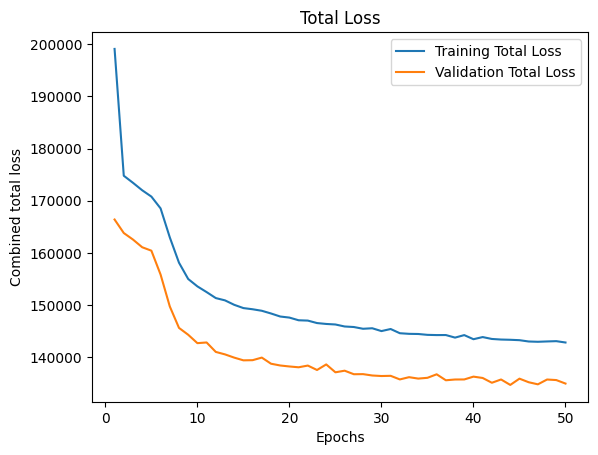

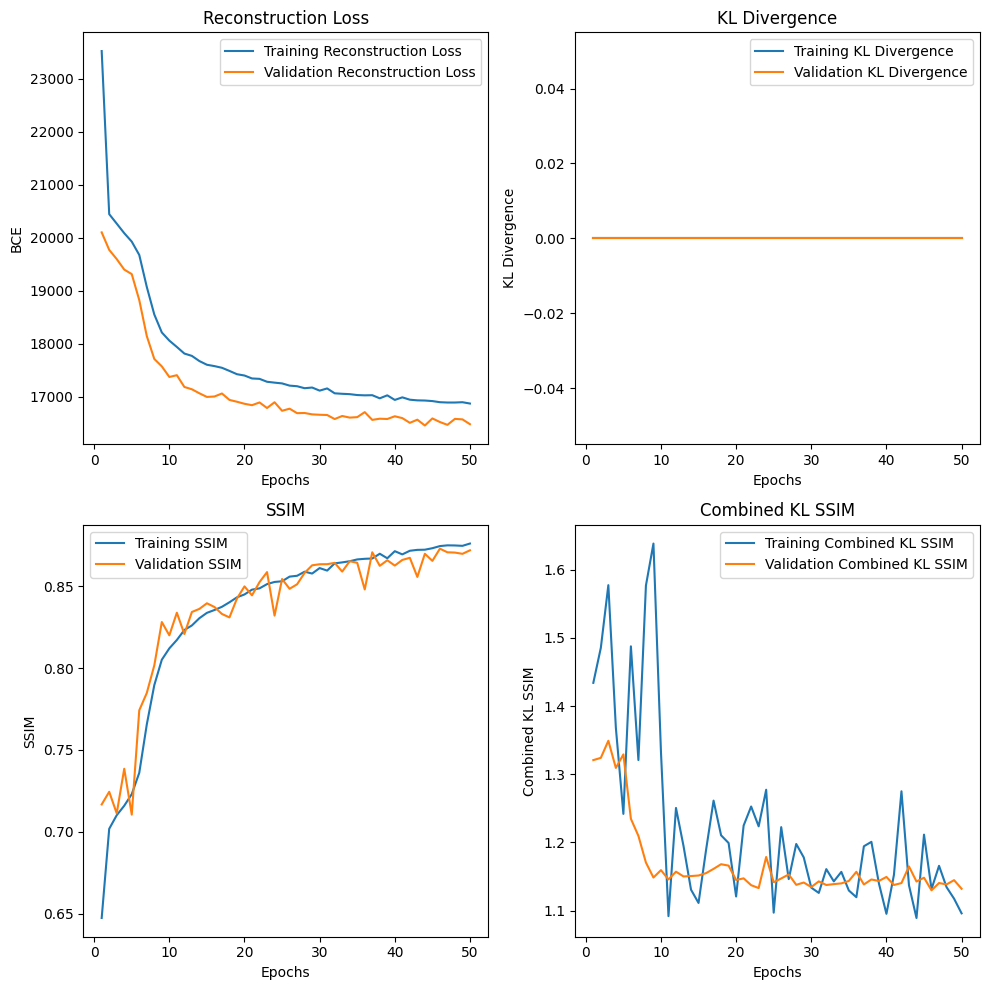

In [ ]:
plot_metrics(history.history)

In [ ]:
loading_model = True
if loading_model:

  ## --- DO CHANGE THESE, MAKE SURE LOAD THE RIGHT ONE --- ##
  # CHANGE THE VAE NAME OR ADD MORE OF THESE IF WANTED


  VAE_parameters_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/VAE2023-04-22_03-32_parameters.pkl"
  encoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/encoder2023-04-22_03-32_weights.h5"
  decoder_weights_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/decoder2023-04-22_03-32_weights.h5"
  history_file = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_default_weights_path/default_history.pkl"
  vae,parameters,history,latent_dim = load_VAE(
      VAE_parameters_file,
      encoder_weights_file,
      decoder_weights_file,
      history_file
      )

buildmode
VAE
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 1024, 192,   0           []                               
                                1)]                                                               
                                                                                                  
 encoder_conv_layer_1 (Conv2D)  (None, 512, 96, 64)  1664        ['encoder_input[0][0]']          
                                                                                                  
 encoder_LeakyReLU_1 (LeakyReLU  (None, 512, 96, 64)  0          ['encoder_conv_layer_1[0][0]']   
 )                                                                                                
                                                                              

In [ ]:
with open("/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spec_weights/VAE2023-04-20_14-01_history.pkl", 'wb') as f:
    pickle.dump(history, f)

##<small> Call the sampling and plotting functions <small>


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.9/bdb.py", line 334, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-30-c7b8696c26d5>(23)plot_latent_space()
     21     else:
     22       pdb.set_trace()
---> 23       z_mean,_,_ = vae.encoder.predict(data)
     24     pdb.set_trace()
     25 

ipdb> data.shape
(1000, 1024, 192, 1)
ipdb> continue



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.9/bdb.py", line 345, in set_continue
    sys.settrace(None)



32/32 [==============================] - 4s 139ms/step
> <ipython-input-30-c7b8696c26d5>(26)plot_latent_space()
     24     pdb.set_trace()
     25 
---> 26     z = pd.DataFrame(z_mean, columns = [f"z[{i}]" for i in range(latent_dim)]) #add as needed
     27     z['label'] = labels
     28 

ipdb> z_mean
array([[-1.2420542 , -1.5744904 , -1.0167737 , ..., -1.3351508 ,
        -0.00556237,  0.25607467],
       [-1.263464  ,  0.24674416, -3.442722  , ..., -1.0542697 ,
        -2.498312  ,  0.51778924],
       [-0.84339106, -0.8768409 , -0.11239101, ...,  0.57772374,
        -1.4595314 , -2.0253065 ],
       ...,
       [-0.5878516 ,  0.7712187 ,  0.46650153, ...,  1.4725269 ,
         1.400018  ,  1.1221337 ],
       [-0.7749631 ,  2.6531098 , -2.7701652 , ...,  1.5629218 ,
        -1.3207476 ,  0.77189577],
       [ 1.7230895 ,  0.18085282,  0.586915  , ..., -0.16977648,
        -0.3589732 , -2.439978  ]], dtype=float32)
ipdb> z_mean.shape
(1000, 8)
ipdb> continue


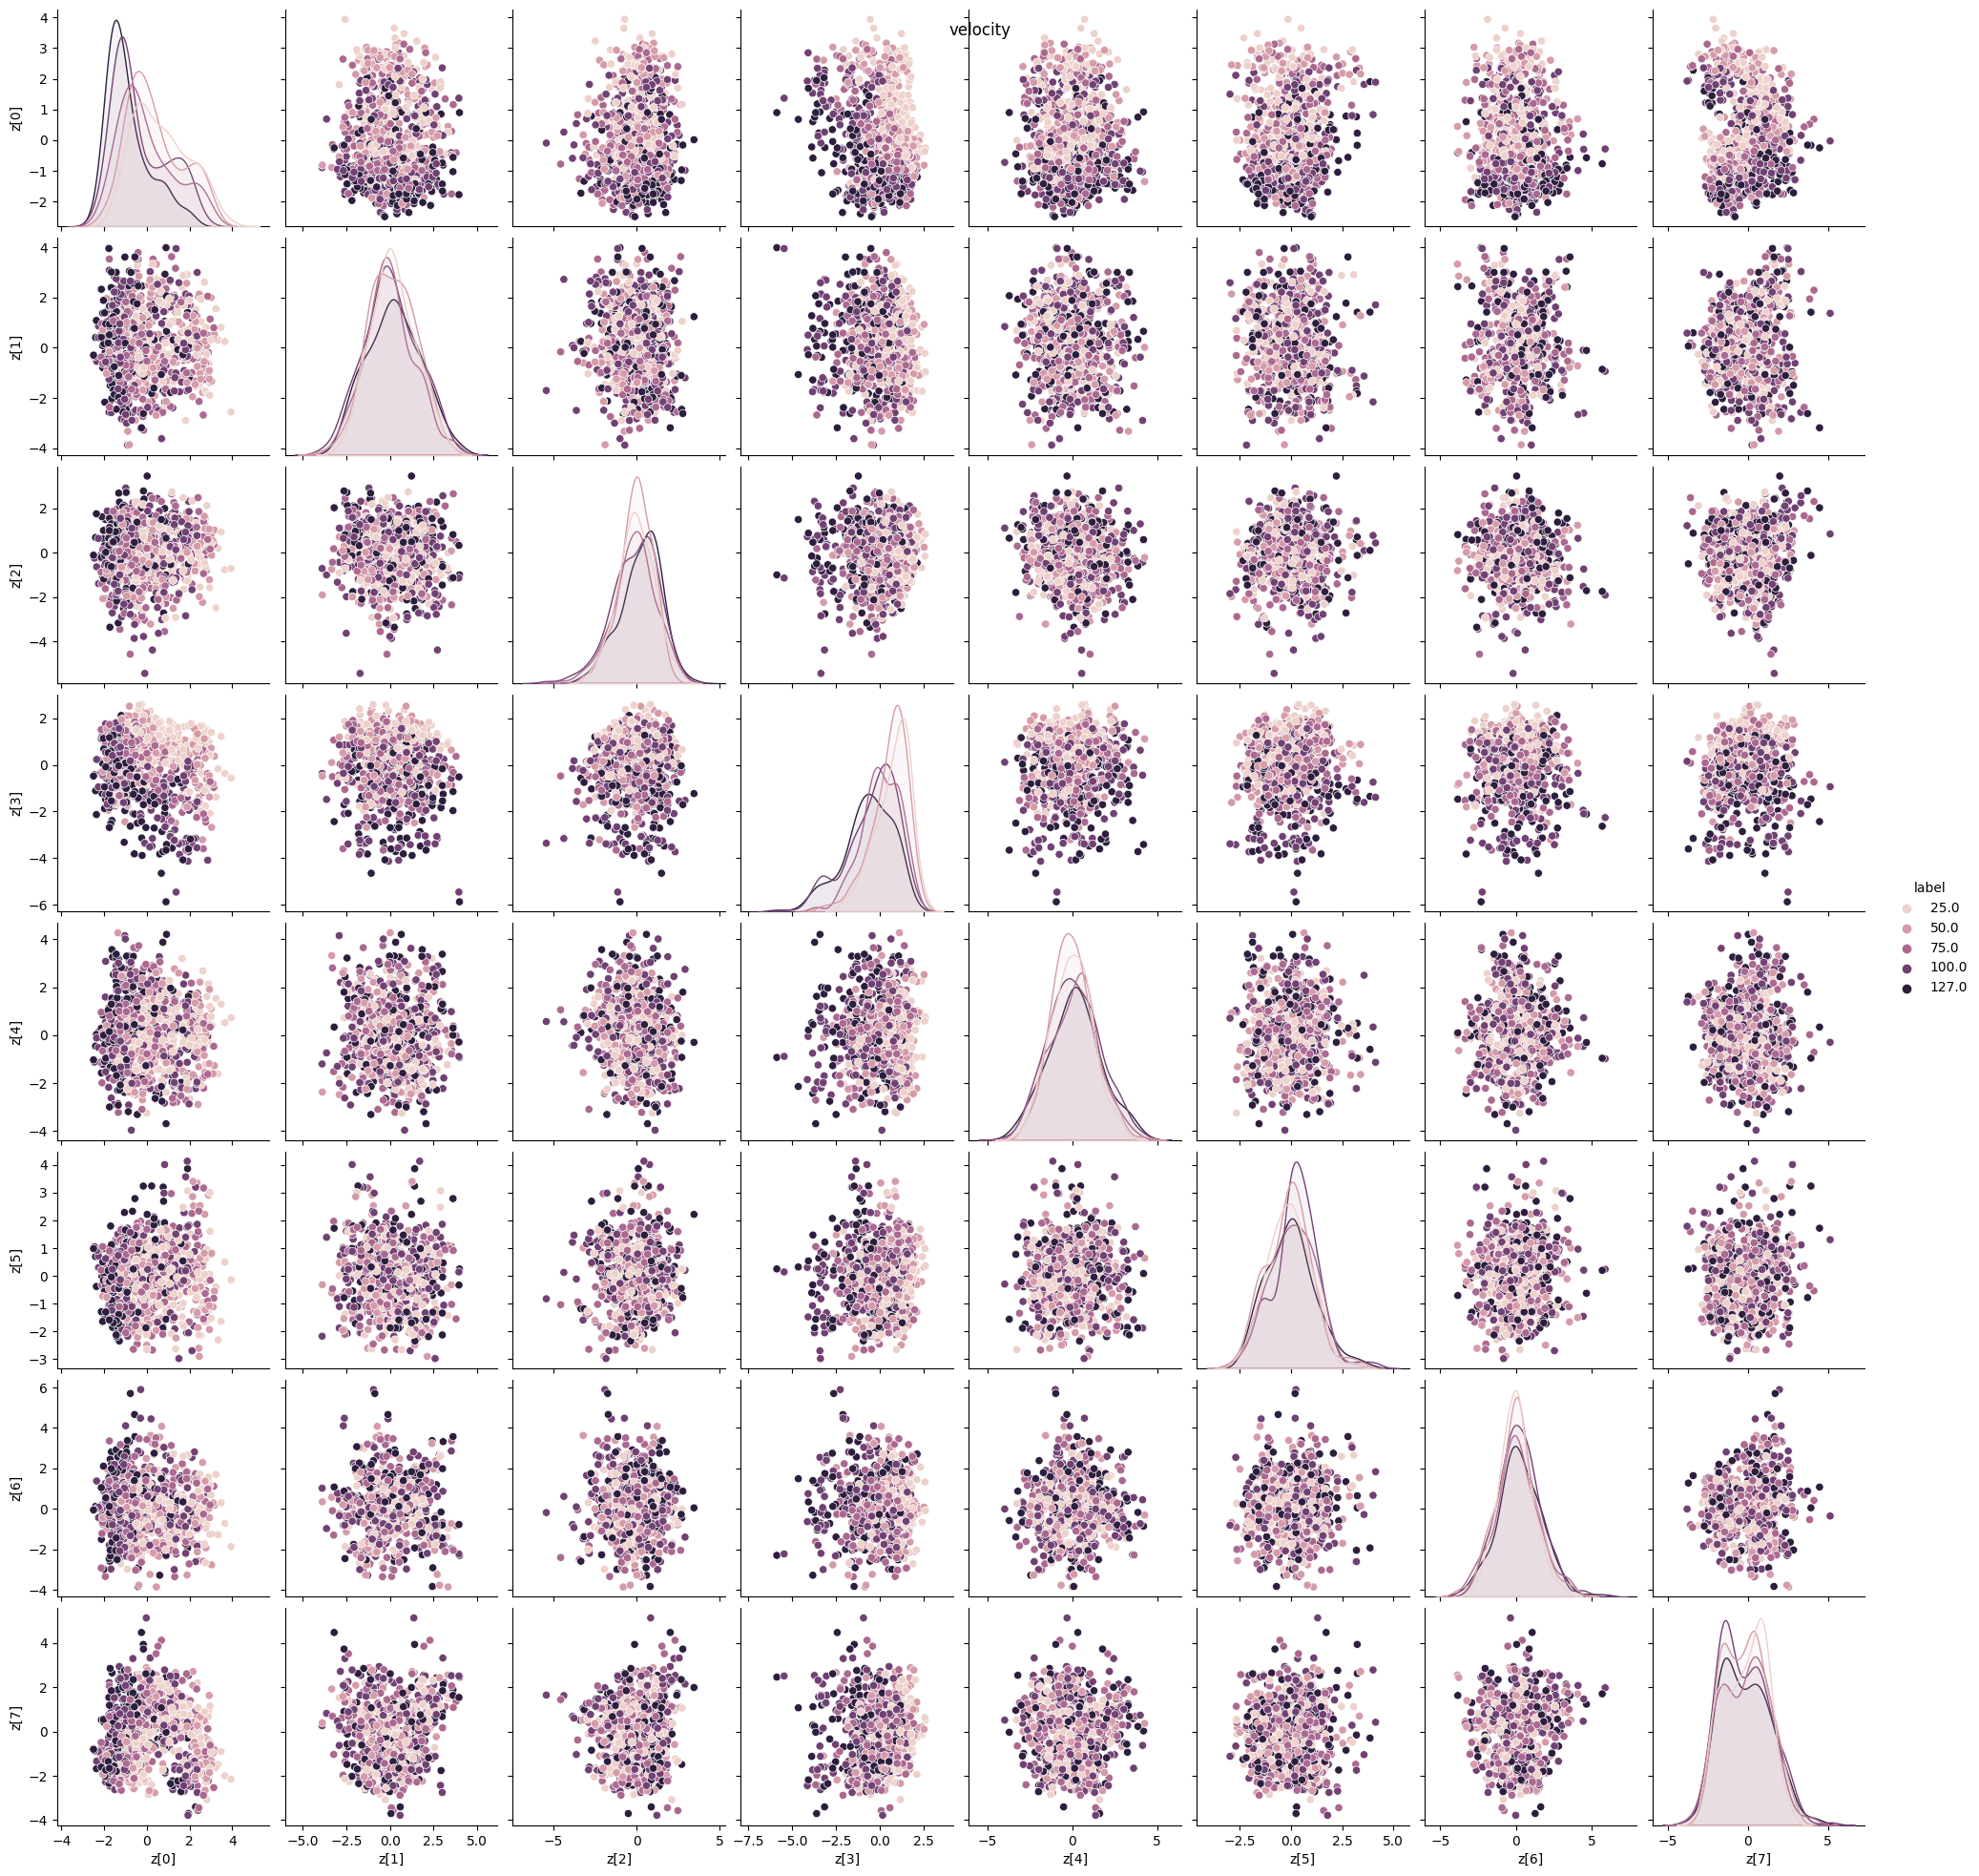

> <ipython-input-30-c7b8696c26d5>(23)plot_latent_space()
     21     else:
     22       pdb.set_trace()
---> 23       z_mean,_,_ = vae.encoder.predict(data)
     24     pdb.set_trace()
     25 




PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.9/bdb.py", line 359, in set_quit
    sys.settrace(None)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/debugger.py", line 1071, in cmdloop
    return OldPdb.cmdloop(self, intro=intro)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
32/32 [==============================] - 3s 101ms/step
> <ipython-input-30-c7b8696c26d5>(26)plot_latent_space()
     24     pdb.set_trace()
     25 
---> 26     z = pd.DataFrame(z_mean, columns = [f"z[{i}]" for i in range(latent_dim)]) #add as needed
     27     z['label'] = labels
     28 

ipdb> continue


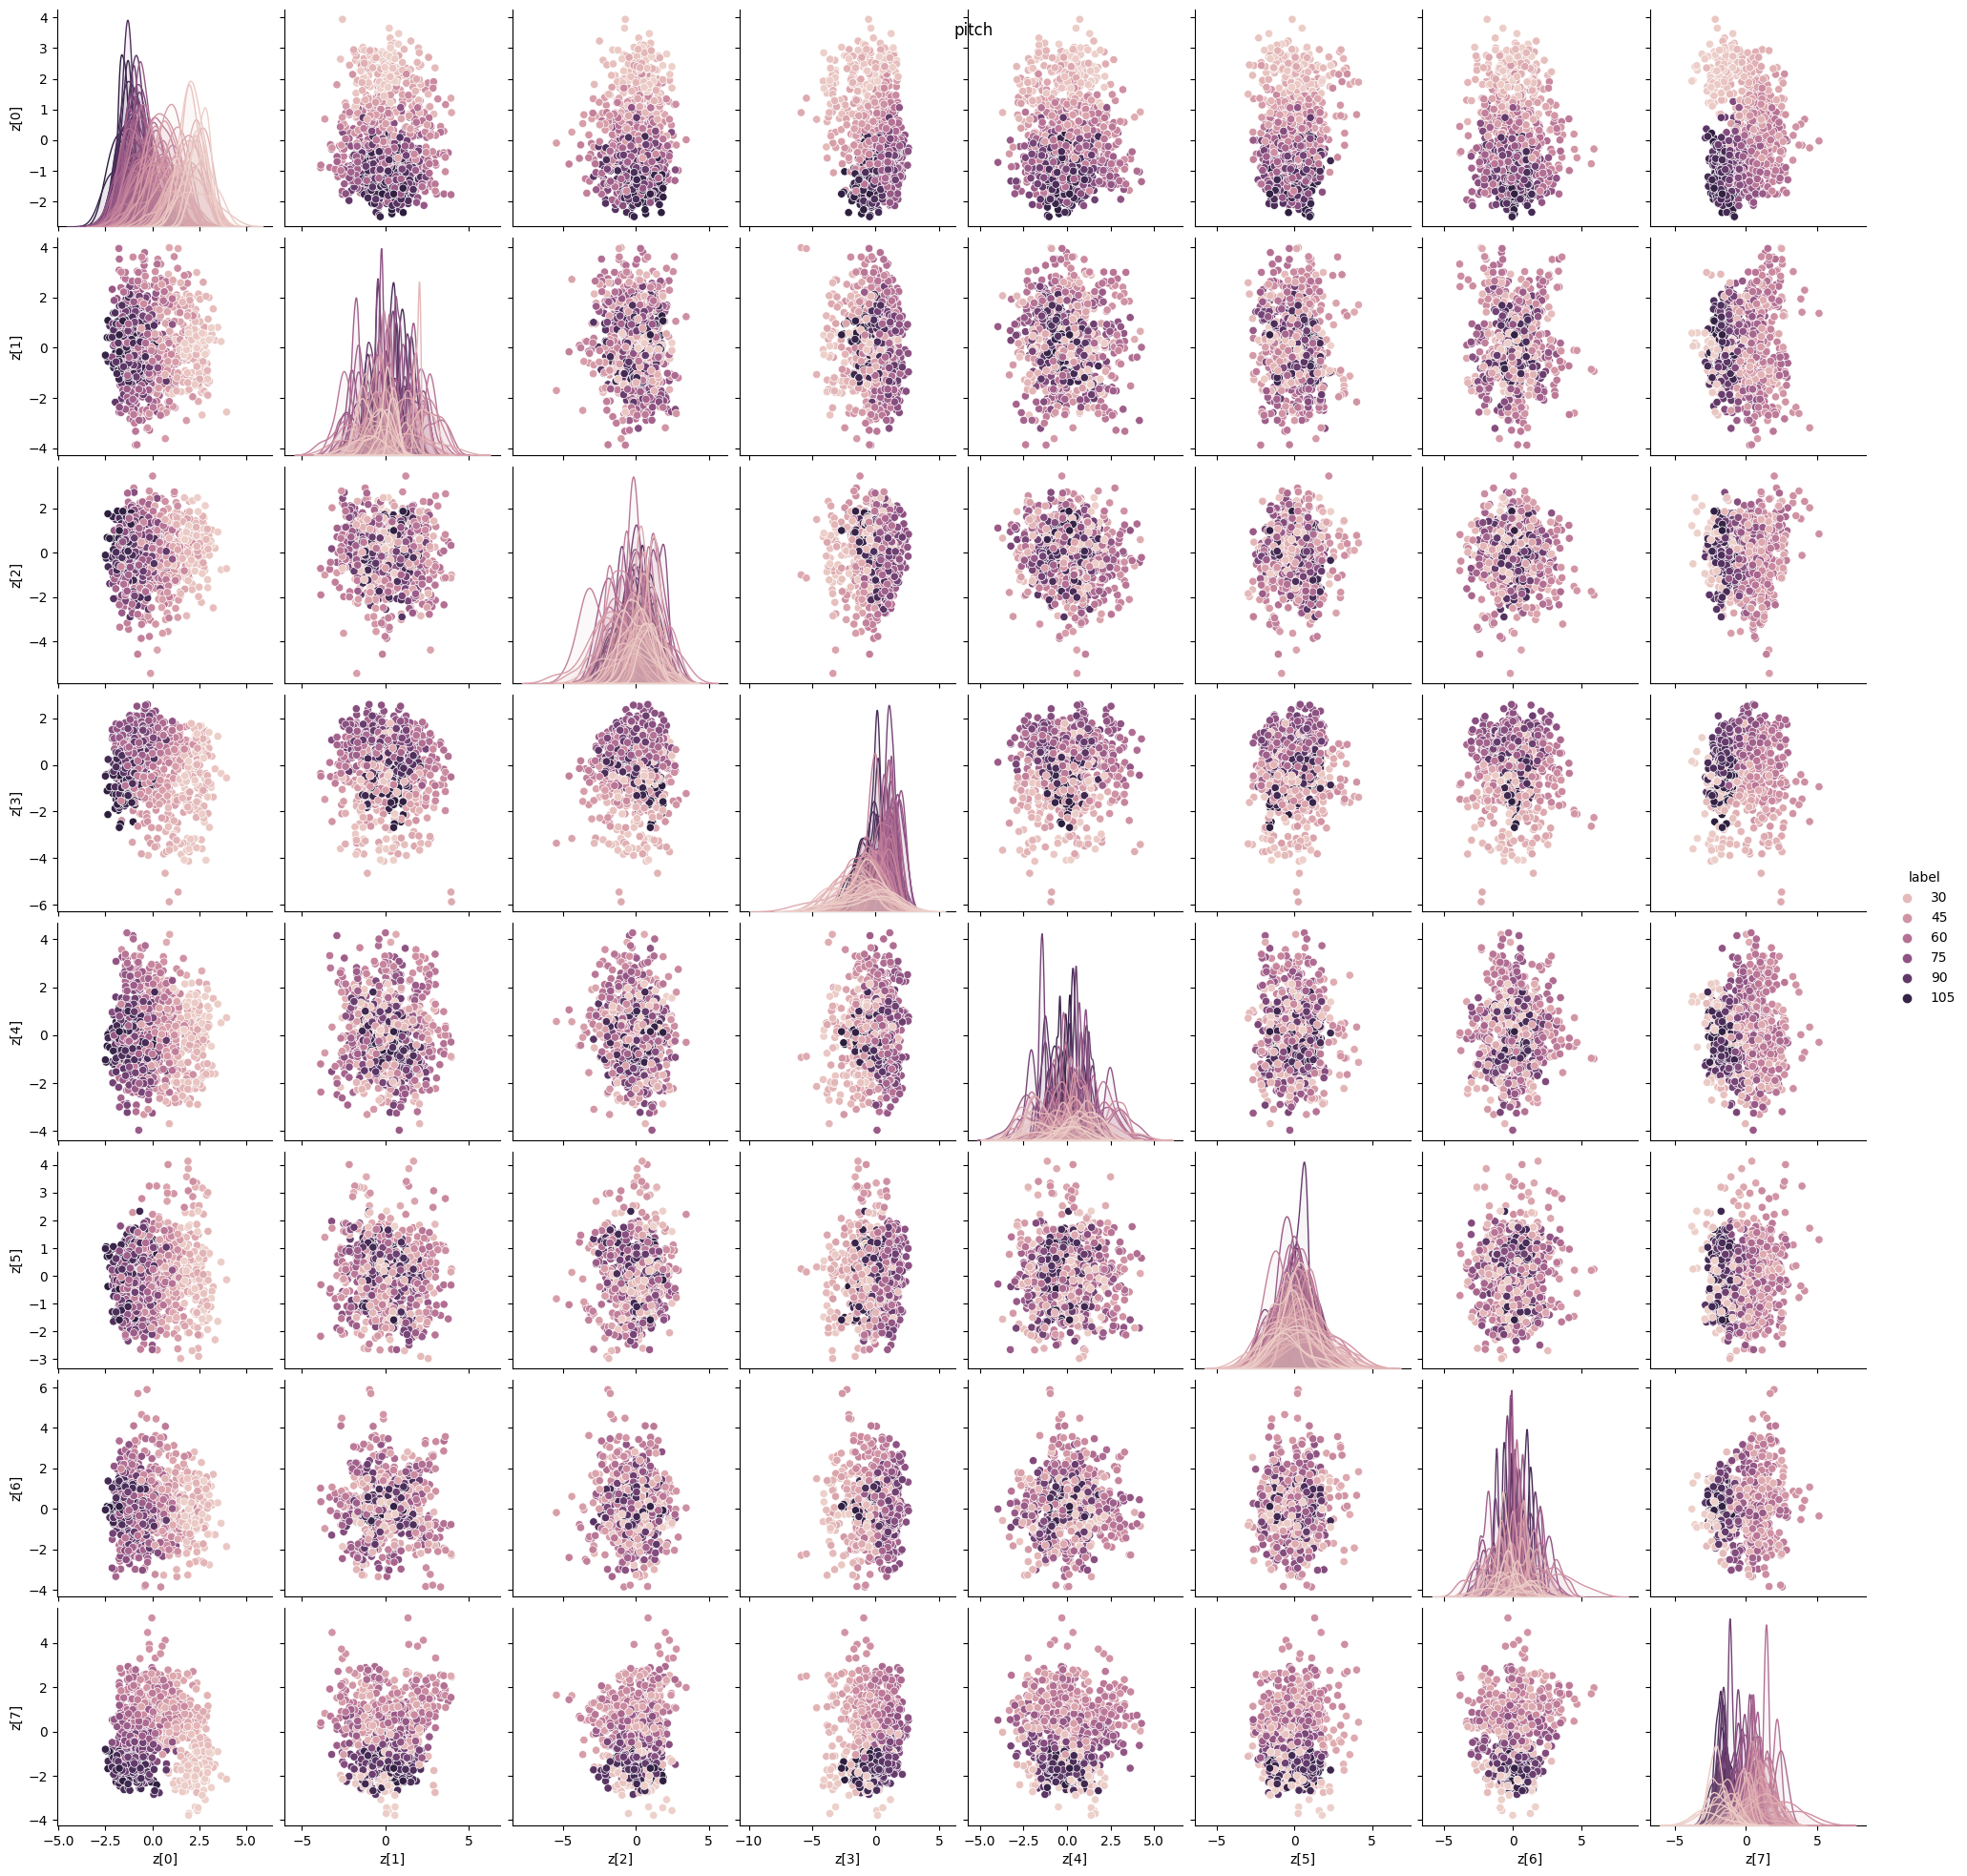

(2, 1024, 192, 1)
1/1 [==============================] - 1s 1s/step


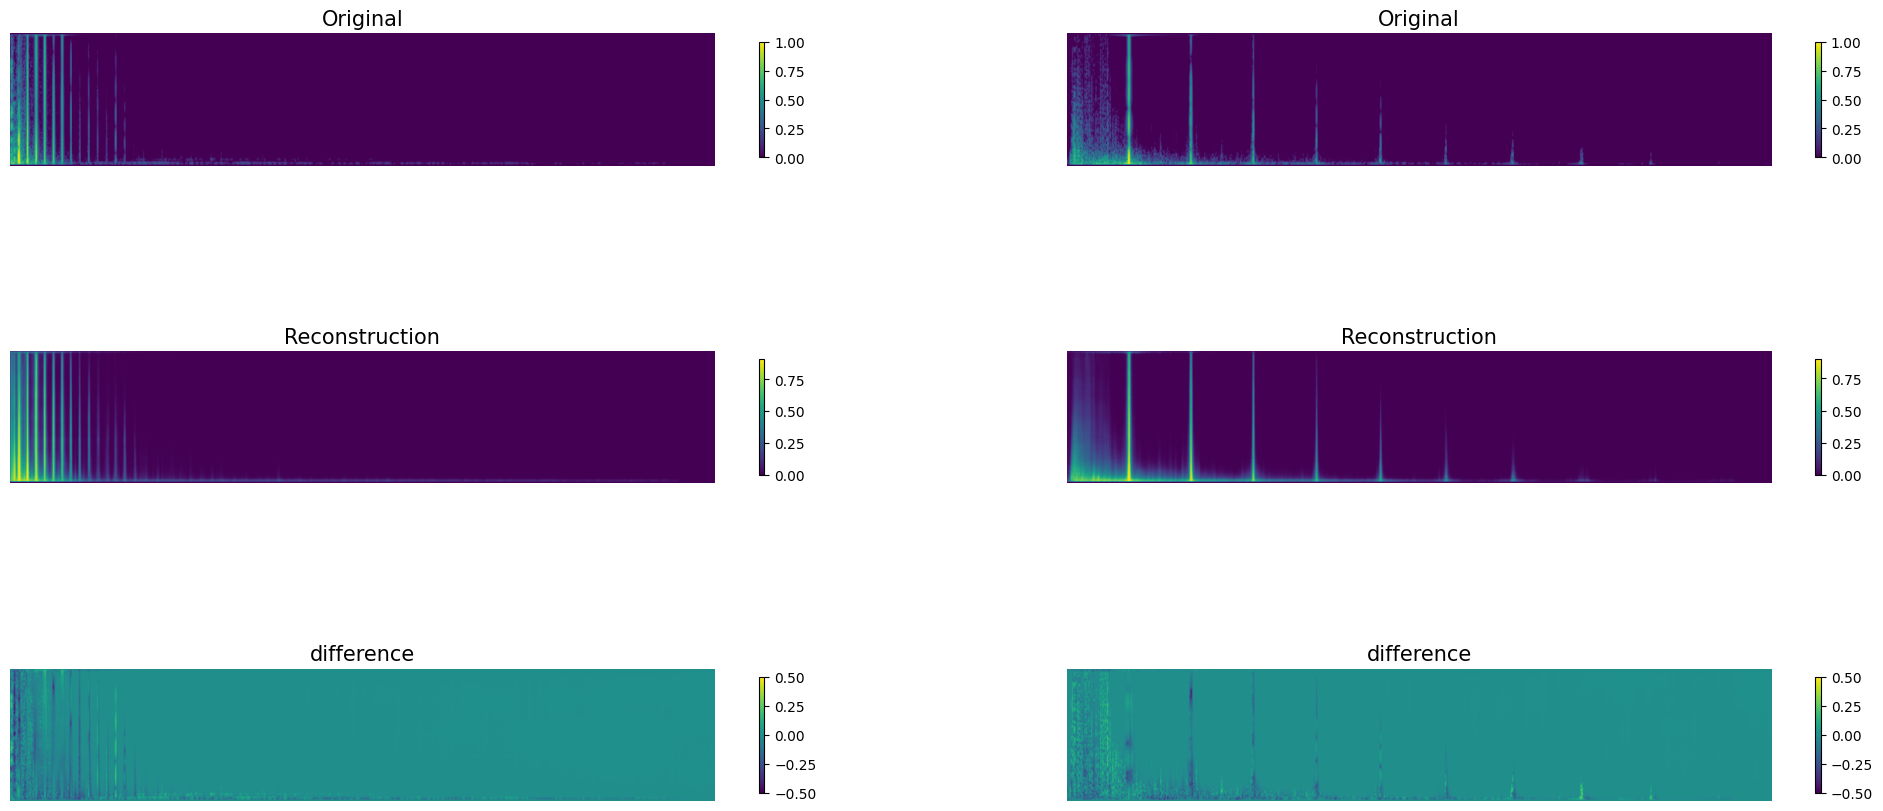

In [ ]:
## Show the pairplots and reconstructions
latent_representation_sample_size = 1000
num_sample_images_to_show = 2

#visualize_latent_space(vae,x_train,label_train,latent_dim,latent_representation_sample_size)

visualize_latent_space(vae,x_train,label_train,latent_dim,latent_representation_sample_size,mode="normal AE")

component = "mag"
plot_reconstruction_and_original_spectrogram(vae,x_train,num_sample_images_to_show,component)


# Generate sound using training samples - passing through VAE


In [ ]:
import os
import random
import numpy as np
import pickle
import librosa
import soundfile as sf

def sample_spectrograms(mag_spectrogram_folder, min_max_values_dict, num_files_to_sample):
    # List all .npy files in the folder
    all_files = [f for f in os.listdir(mag_spectrogram_folder) if f.endswith('.npy')]
    
    # Randomly sample `num_files_to_sample` files
    sample_size = num_files_to_sample
    sampled_files = random.sample(all_files, sample_size)
    
    # Load each sampled file as a numpy array and concatenate them into a 3D array
    sampled_mag_specs = []
    sampled_min_max_values = []
    for file in sampled_files:
        mag_file_path = os.path.join(mag_spectrogram_folder, file)
        sampled_mag_spec = np.load(mag_file_path)
        sampled_mag_specs.append(sampled_mag_spec)

        sampled_min_max_values.append(min_max_values_dict[mag_file_path])
        
    sampled_mag_specs = np.array(sampled_mag_specs)
    sampled_mag_specs = sampled_mag_specs[..., np.newaxis] # -> (num_files_to_sample, 1024, 188, 1)

    return sampled_mag_specs, sampled_min_max_values

def denormalise(norm_array, original_min, original_max):
    denormal_array = norm_array * (original_max - original_min) + original_min
    return denormal_array

def griffin_lim(mag_spectrogram, n_iter=100, hop_length=256, win_length=2048):

    phase = np.random.rand(*mag_spectrogram.shape)
    for _ in range(n_iter):
        #pdb.set_trace()
        spec = mag_spectrogram * np.exp(1j * phase)
        #pdb.set_trace()
        signal = librosa.istft(spec, hop_length=hop_length)

        phase = np.angle(librosa.stft(signal, n_fft=2048, hop_length=hop_length, center = True)[:-1])
    return signal

def convert_spectrograms_to_audio(mag_spectrograms, min_max_values, hop_length, win_length=2048, n_iter=100):

    signals = []
    for mag_spectrogram, min_max_value in zip(mag_spectrograms, min_max_values):
        # reshape the log spectrogram
        mag_spectrogram = mag_spectrogram[:, :, 0]
        # apply denormalisation
        denorm_mag_spec = denormalise(mag_spectrogram, min_max_value["min"], min_max_value["max"])
        # log spectrogram -> normal scale spectrogram
        mag_spectrogram = librosa.db_to_amplitude(denorm_mag_spec)

        # apply Griffin-Lim algorithm for phase reconstruction
        signal = griffin_lim(mag_spectrogram, n_iter=n_iter, hop_length=hop_length, win_length=win_length)



        
        # append signal to "signals"
        signals.append(signal)
    return signals

def save_signals(signals, save_dir, sample_rate=16000):
    for i, signal in enumerate(signals):
        save_path = os.path.join(save_dir, str(i) + ".wav")
        sf.write(save_path, signal, sample_rate)

def generate_sounds_and_save(mag_vae,
                             mag_spectrogram_folder = "/path/to/mag_spectrogram_folder",
                             min_max_values_file_path = "/path/to/min_max_values_file",
                             original_sound_save_folder="/path/to/original_sound_save_folder",
                             generated_sound_save_folder="/path/to/generated_sound_save_folder",
                             hop_length = 256,
                             window_length = 2048,
                             num_sounds_generated = 5,
                             n_iter = 100):

    # Load the min_max values used in normalizing the originals
    with open(min_max_values_file_path, "rb") as f:
        min_max_values = pickle.load(f)

    # Load and sample spectrograms 
    sampled_mag_specs, sampled_min_max_values = sample_spectrograms(mag_spectrogram_folder, min_max_values, num_sounds_generated)

    # Assuming the same 1024x188 spectrograms.
    sampled_mag_specs = np.pad(sampled_mag_specs, ((0, 0), (0, 0), (2, 2), (0, 0)), mode='constant')  # Pad the data

    mag_z_mean, _, _ = mag_vae.encoder.predict(sampled_mag_specs)
    generated_mag_specs = mag_vae.decoder.predict(mag_z_mean)

    # Get the generated signals
    signals = convert_spectrograms_to_audio(generated_mag_specs, sampled_min_max_values, hop_length, win_length=window_length, n_iter=n_iter)


    # Convert spectrogram samples to audio
    original_signals = convert_spectrograms_to_audio(sampled_mag_specs, sampled_min_max_values, hop_length, win_length=window_length, n_iter=n_iter)



    # Save audio signals
    save_signals(signals, generated_sound_save_folder)
    save_signals(original_signals, original_sound_save_folder)


In [ ]:
generate_sounds_and_save(vae,
                        mag_spectrogram_folder = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_spectrograms",
                        min_max_values_file_path = "/content/drive/MyDrive/Variational_Auto_Encoder/Acoustic_log_MinMaxVals/min_max_values.pkl",
                        original_sound_save_folder="/content/drive/MyDrive/Variational_Auto_Encoder/Original",
                        generated_sound_save_folder="/content/drive/MyDrive/Variational_Auto_Encoder/Generated",
                        hop_length = 256,
                        window_length=2048,
                        num_sounds_generated = 5,
                        n_iter = 100)